# Prediction Diabetes using Random Forest Algorithm

# Business Problem

In this section we are planing to predict the diabetes by specific parameters and refered parameters are described as:

# Dataset Story

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.2
From the data set in the (.csv) File We can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).

### Dataset Features

Pregnancies: To express the Number of pregnancies

Glucose: To express the Glucose level in blood

BloodPressure: To express the Blood pressure measurement

SkinThickness: To express the thickness of the skin

Insulin: To express the Insulin level in blood

BMI: To express the Body mass index

DiabetesPedigreeFunction: To express the Diabetes percentage

Age: To express the age

Outcome: To express the final result 1 is Yes and 0 is No

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [130]:
diabetes = pd.read_csv('/kaggle/input/diabetes-dataset')
df = diabetes.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6000,0.6270,50,1
1,1,85,66,29,0,26.6000,0.3510,31,0
2,8,183,64,0,0,23.3000,0.6720,32,1
3,1,89,66,23,94,28.1000,0.1670,21,0
4,0,137,40,35,168,43.1000,2.2880,33,1


# General Information About the Dataset

In [131]:
def check_df(dataframe, head=5, tail=5):
  print('#'*20, 'HEAD', '#'*20)
  print(dataframe.head(head))
  print('#'*20, 'TAIL', '#'*20)
  print(dataframe.tail(tail))
  print('#'*20, 'SHAPE', '#'*20)
  print(dataframe.shape)
  print('#'*20, 'TYPES', '#'*20)
  print(dataframe.dtypes)
  print('#'*20, 'SIZE', '#'*20)
  print(dataframe.size)
  print('#'*20, 'NA', '#'*20)
  print(dataframe.isnull().sum())
  print('#'*20, 'QUARTILES', '#'*20)
  print(dataframe.describe([0, 0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]).T)

In [132]:
check_df(df)

#################### HEAD ####################

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction  Age  Outcome

0            6      148             72             35        0 33.6000                    0.6270   50        1

1            1       85             66             29        0 26.6000                    0.3510   31        0

2            8      183             64              0        0 23.3000                    0.6720   32        1

3            1       89             66             23       94 28.1000                    0.1670   21        0

4            0      137             40             35      168 43.1000                    2.2880   33        1

#################### TAIL ####################

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction  Age  Outcome

763           10      101             76             48      180 32.9000                    0.1710   63        0

764 

In [133]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ['category', 'object', 'bool']]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ['uint8', 'int64', 'int32', 'float64']]
  cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and str(df[col].dtypes) in ['object', 'category']]
  cat_cols = cat_cols + num_but_cat
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['uint8', 'int64', 'float64']]
  num_cols = [col for col in num_cols if col not in cat_cols]
  return cat_cols, num_cols, cat_but_car, num_but_cat

grab_col_names(df)


(['Outcome'],
 ['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age'],
 [],
 ['Outcome'])

In [134]:
def cat_summary(dataframe, col_name, plot=False):
  print(f'############### {col_name} ###############')
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      'Ratio': 100 * df[col_name].value_counts() / len(dataframe)}))
  if plot:
    sns.countplot(x=dataframe[col_name], data=dataframe)
    plt.show(block=True)



In [135]:
def cat_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in cat_cols:
    if dataframe[col].dtypes == 'bool':
      new_df = pd.DataFrame()
      new_df[col] = dataframe[col].astype(int)
      cat_summary(new_df, col, plot=True)
    else:
      cat_summary(dataframe, col, plot=True)

############### Outcome ###############

         Outcome   Ratio

Outcome                 

0            500 65.1042

1            268 34.8958


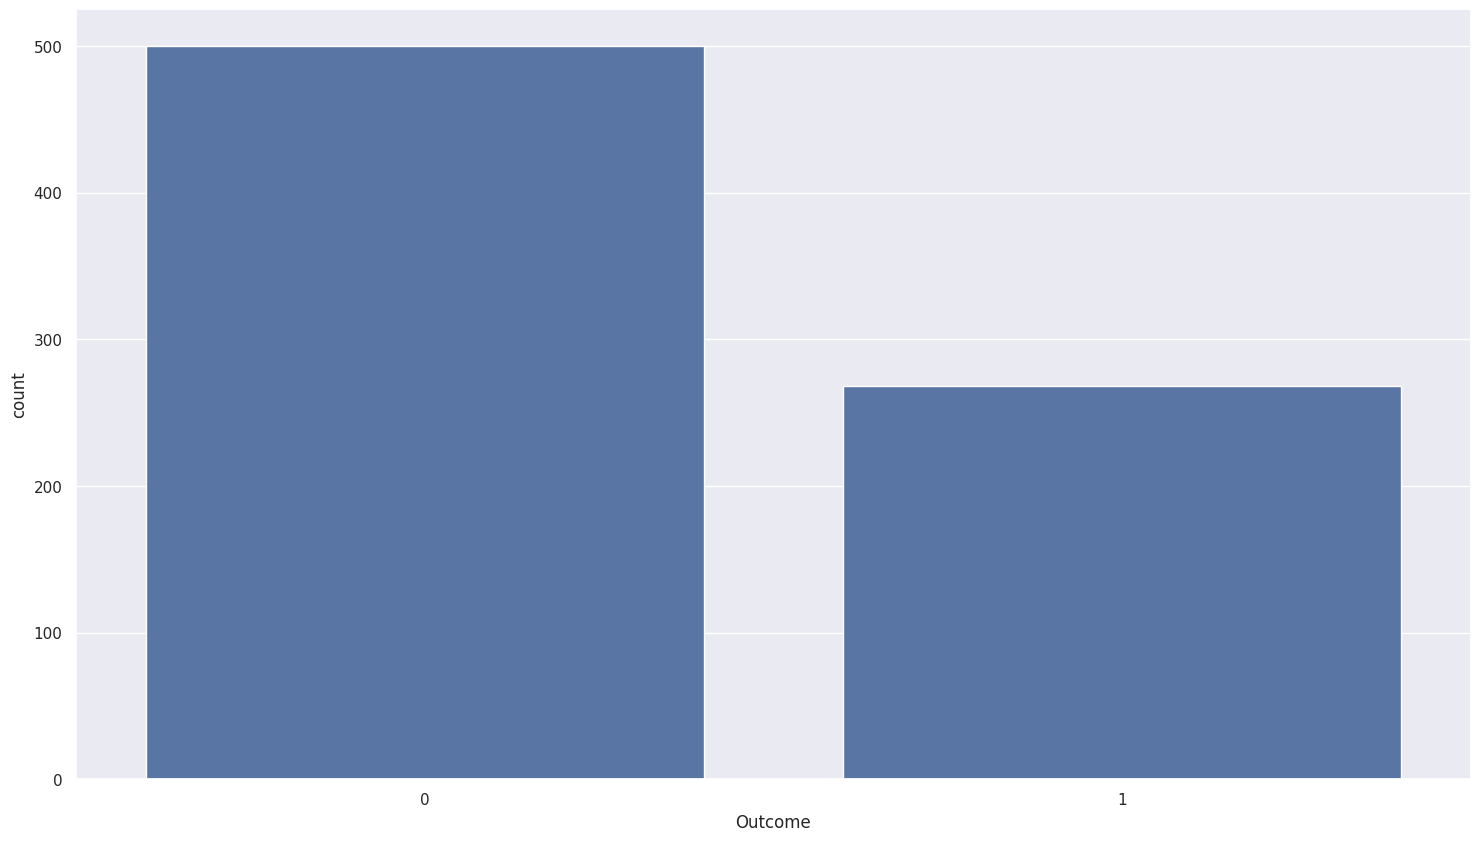

In [136]:
cat_summary_df(df)

In [137]:
def num_summary(dataframe, num_col, plot=False):
  print(f'############### {num_col} ###############')
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.ylabel(num_col)
    plt.show(block=True)

In [138]:
def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

############### Pregnancies ###############

count   768.0000

mean      3.8451

std       3.3696

min       0.0000

1%        0.0000

5%        0.0000

10%       0.0000

20%       1.0000

30%       1.0000

40%       2.0000

50%       3.0000

60%       4.0000

70%       5.0000

80%       7.0000

90%       9.0000

95%      10.0000

99%      13.0000

max      17.0000

Name: Pregnancies, dtype: float64


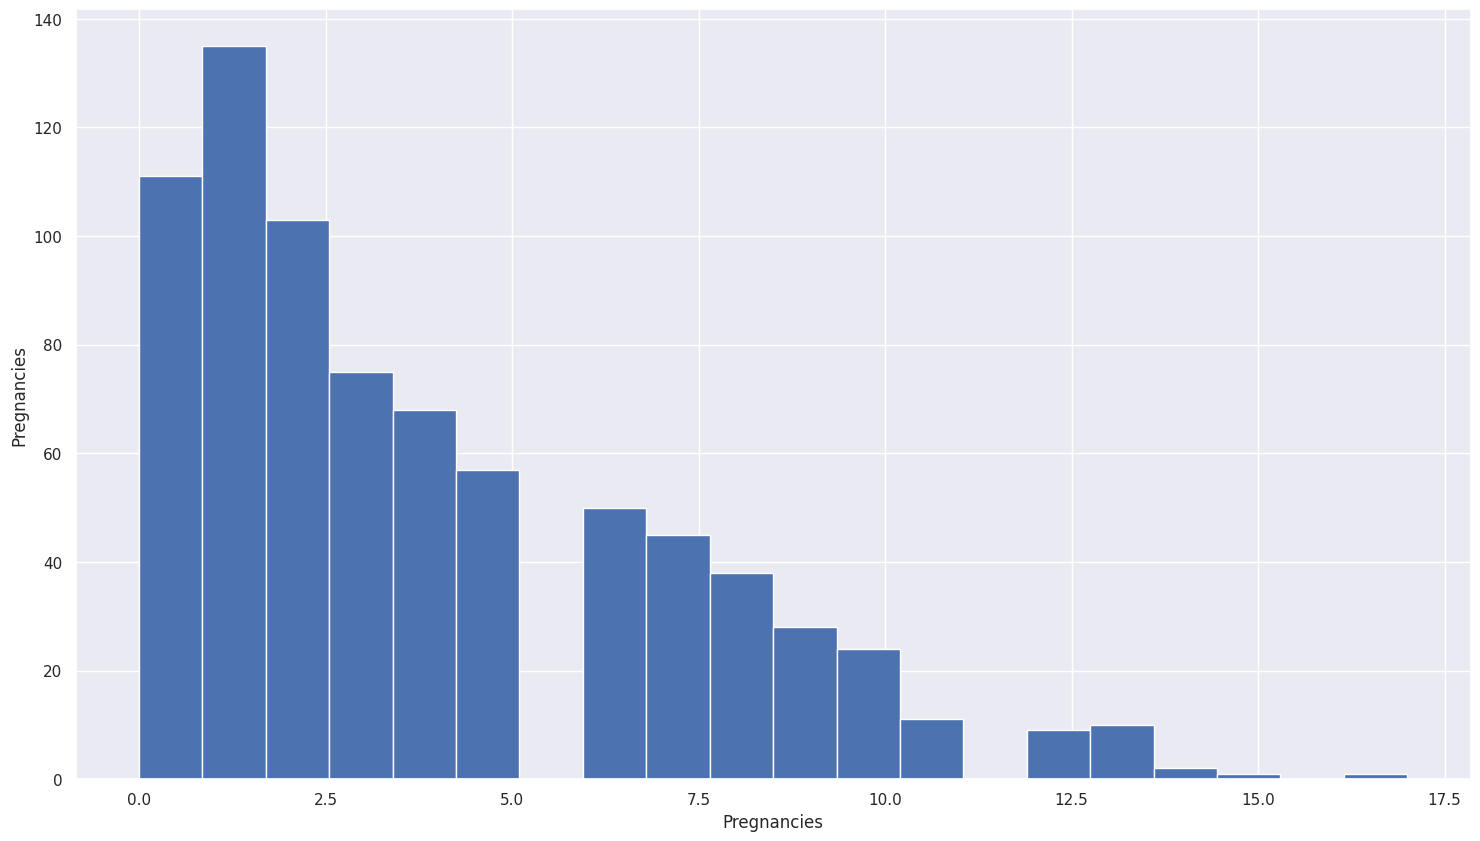

############### Glucose ###############

count   768.0000

mean    120.8945

std      31.9726

min       0.0000

1%       57.0000

5%       79.0000

10%      85.0000

20%      95.0000

30%     102.0000

40%     109.0000

50%     117.0000

60%     125.0000

70%     134.0000

80%     147.0000

90%     167.0000

95%     181.0000

99%     196.0000

max     199.0000

Name: Glucose, dtype: float64


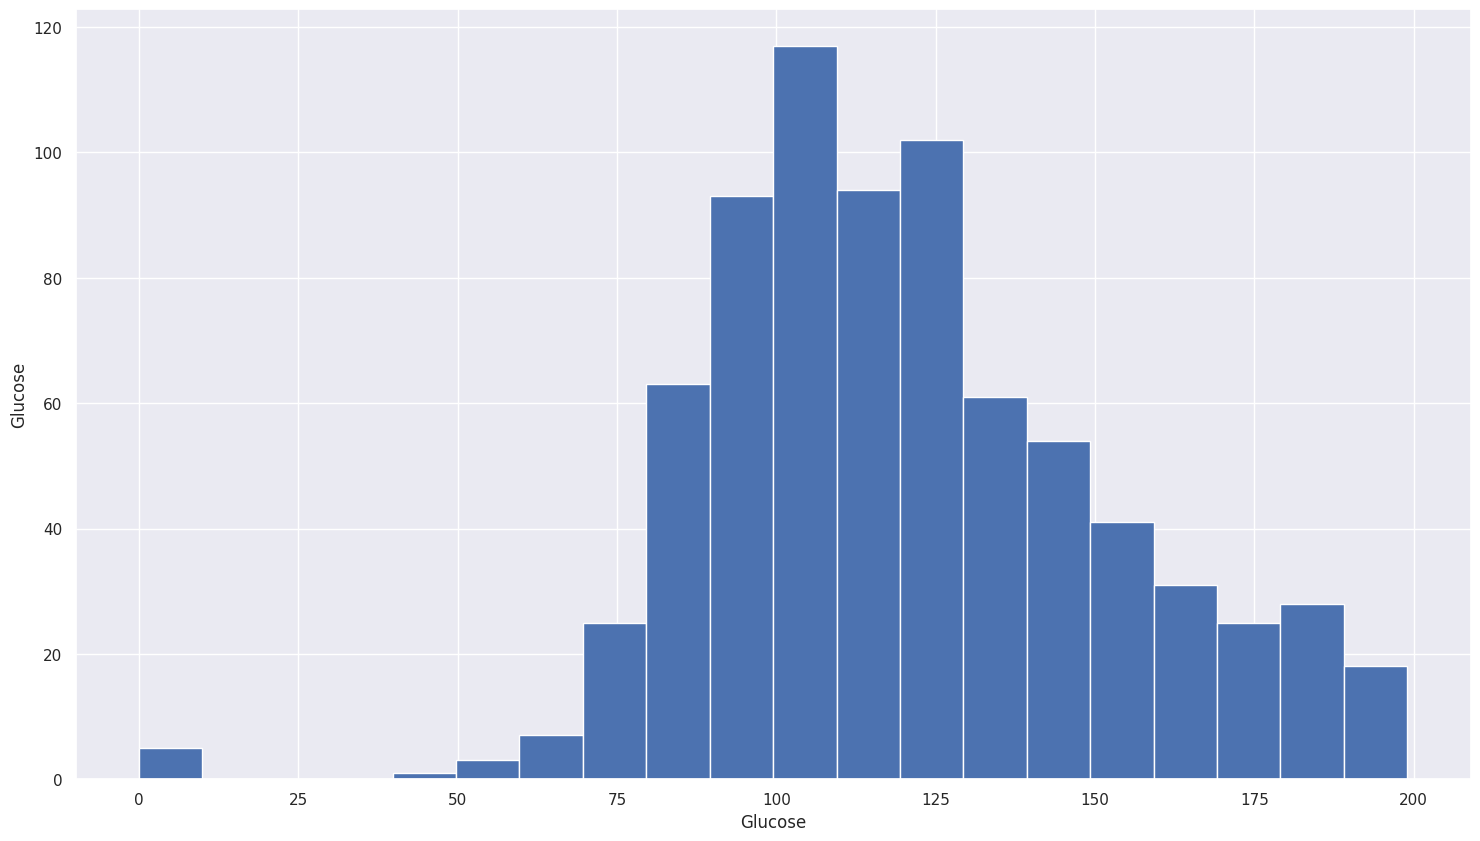

############### BloodPressure ###############

count   768.0000

mean     69.1055

std      19.3558

min       0.0000

1%        0.0000

5%       38.7000

10%      54.0000

20%      60.0000

30%      64.0000

40%      68.0000

50%      72.0000

60%      74.0000

70%      78.0000

80%      82.0000

90%      88.0000

95%      90.0000

99%     106.0000

max     122.0000

Name: BloodPressure, dtype: float64


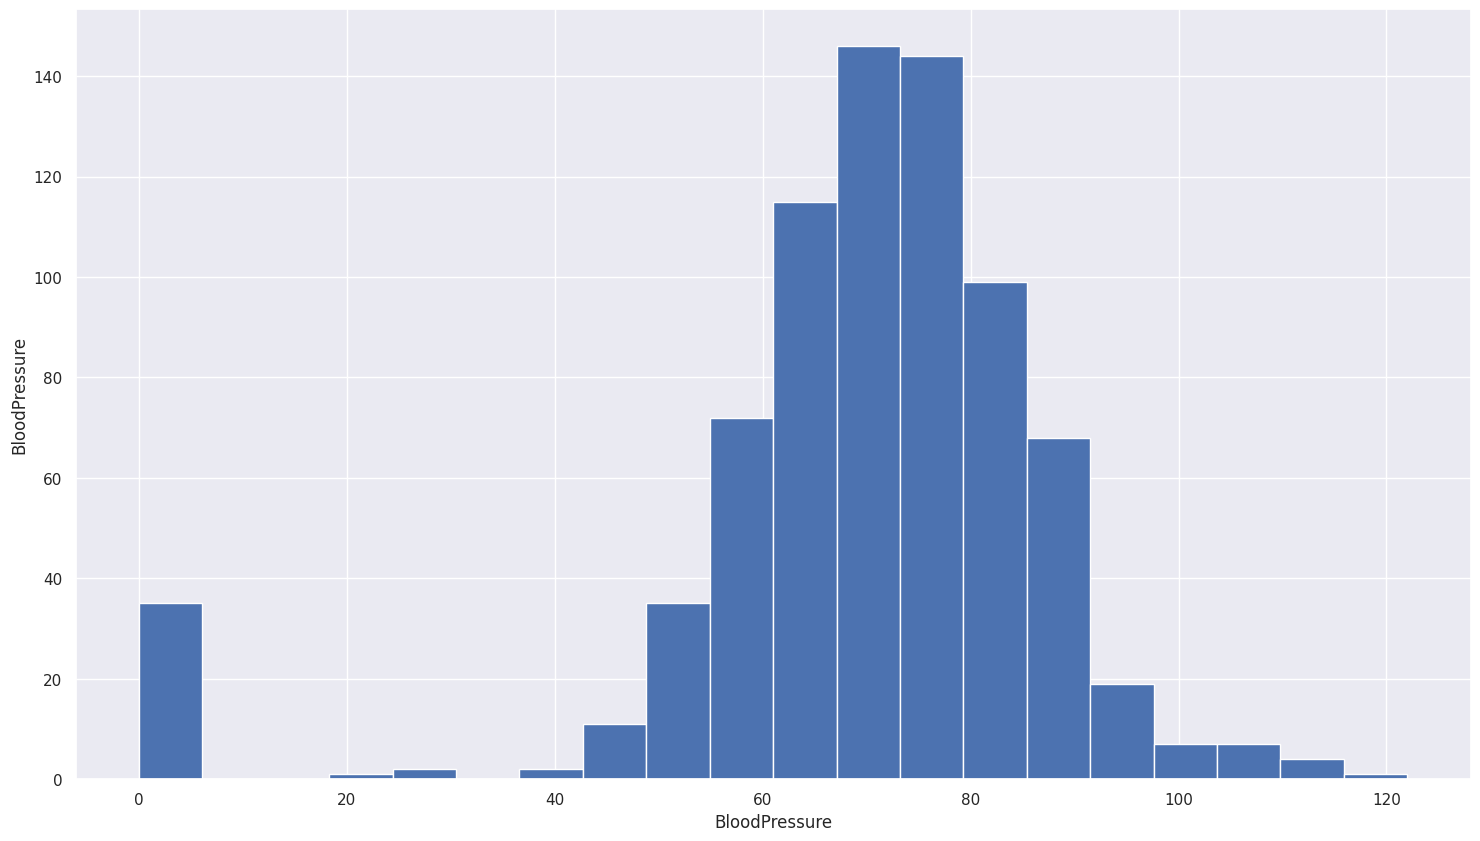

############### SkinThickness ###############

count   768.0000

mean     20.5365

std      15.9522

min       0.0000

1%        0.0000

5%        0.0000

10%       0.0000

20%       0.0000

30%       8.2000

40%      18.0000

50%      23.0000

60%      27.0000

70%      31.0000

80%      35.0000

90%      40.0000

95%      44.0000

99%      51.3300

max      99.0000

Name: SkinThickness, dtype: float64


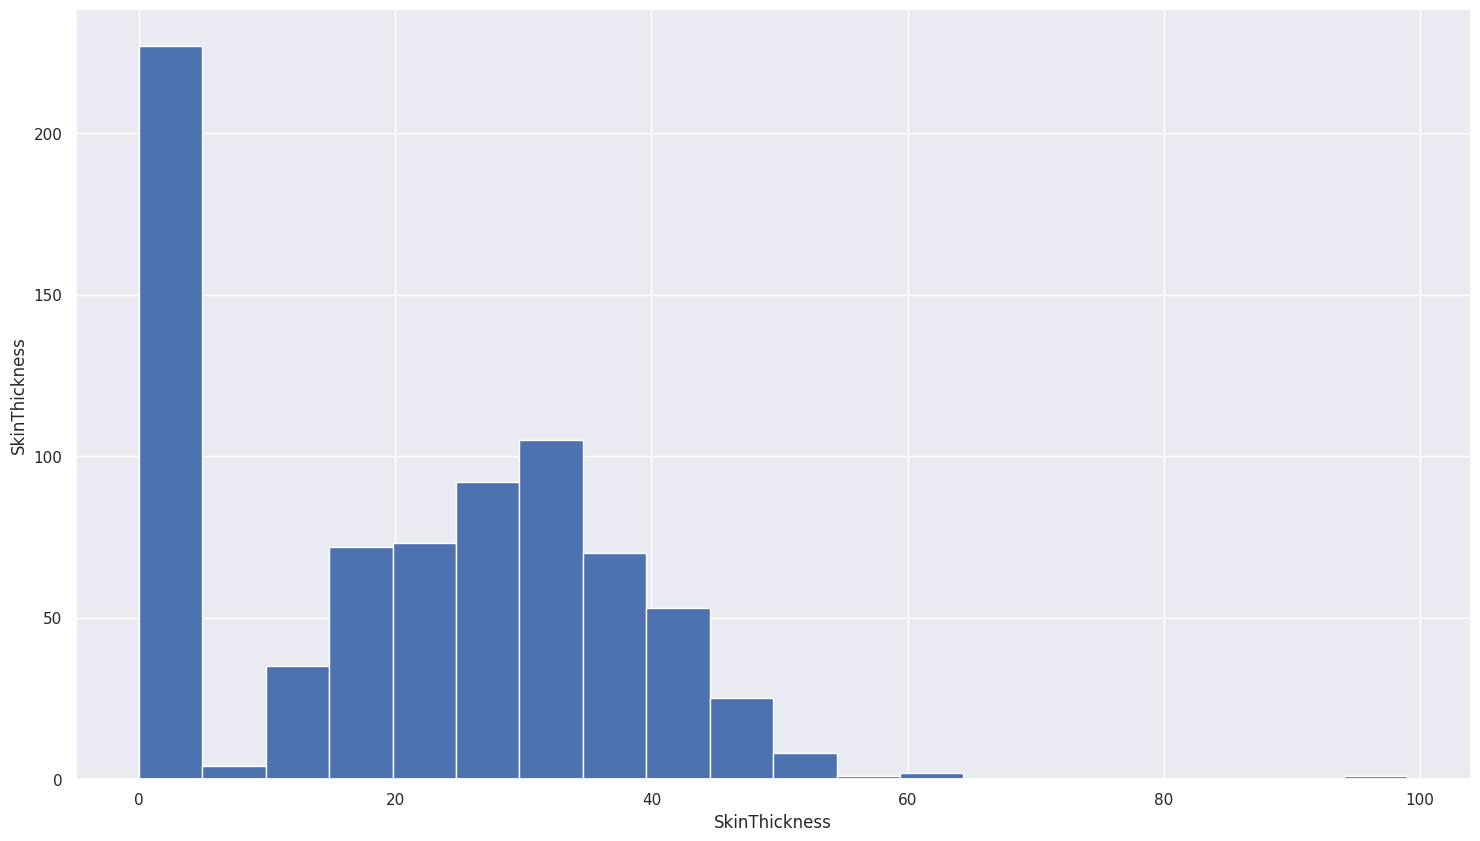

############### Insulin ###############

count   768.0000

mean     79.7995

std     115.2440

min       0.0000

1%        0.0000

5%        0.0000

10%       0.0000

20%       0.0000

30%       0.0000

40%       0.0000

50%      30.5000

60%      72.2000

70%     106.0000

80%     150.0000

90%     210.0000

95%     293.0000

99%     519.9000

max     846.0000

Name: Insulin, dtype: float64


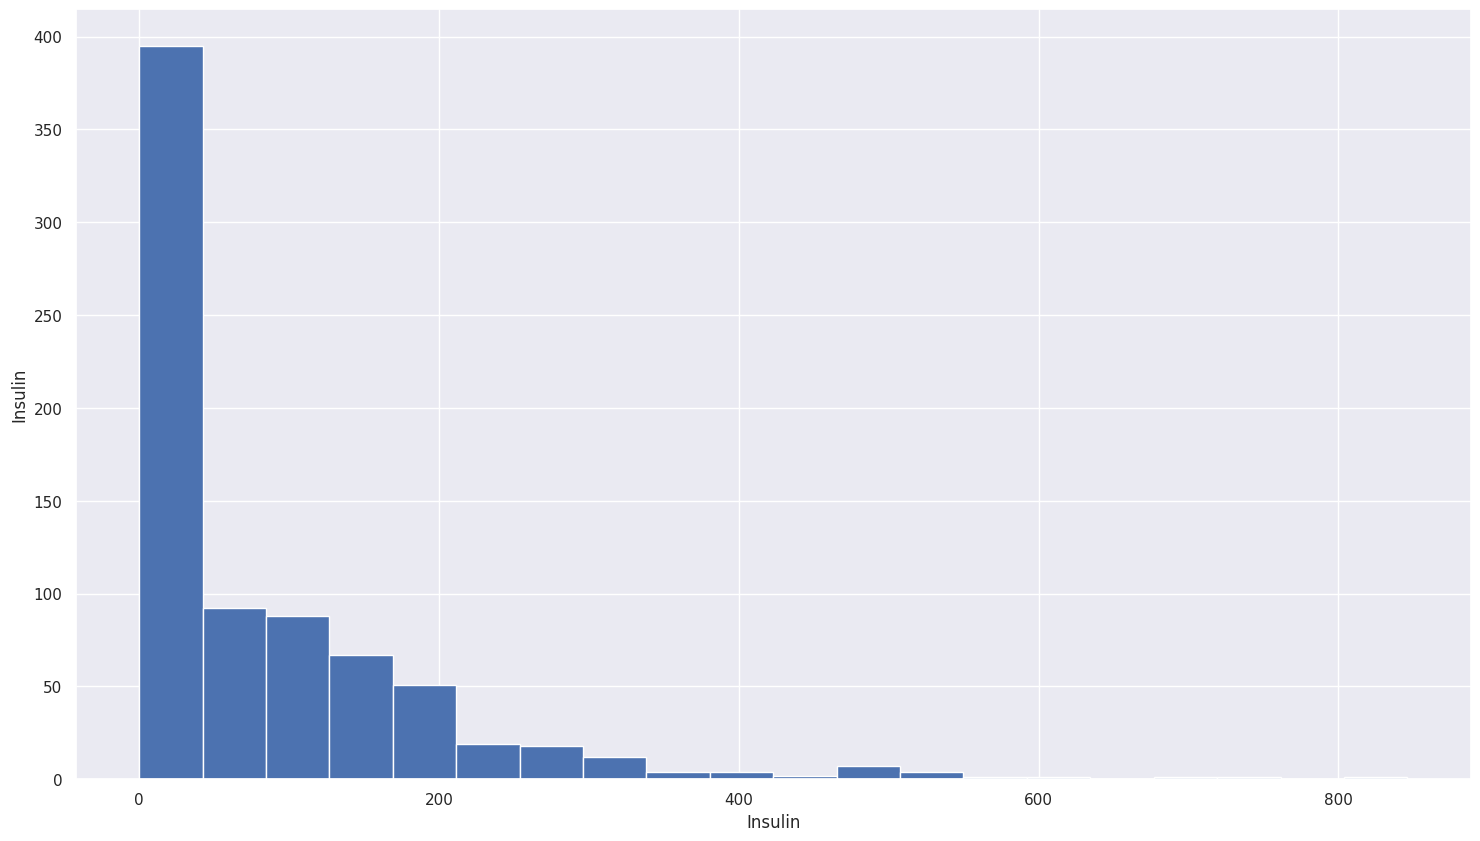

############### BMI ###############

count   768.0000

mean     31.9926

std       7.8842

min       0.0000

1%        0.0000

5%       21.8000

10%      23.6000

20%      25.9000

30%      28.2000

40%      30.1000

50%      32.0000

60%      33.7000

70%      35.4900

80%      37.8000

90%      41.5000

95%      44.3950

99%      50.7590

max      67.1000

Name: BMI, dtype: float64


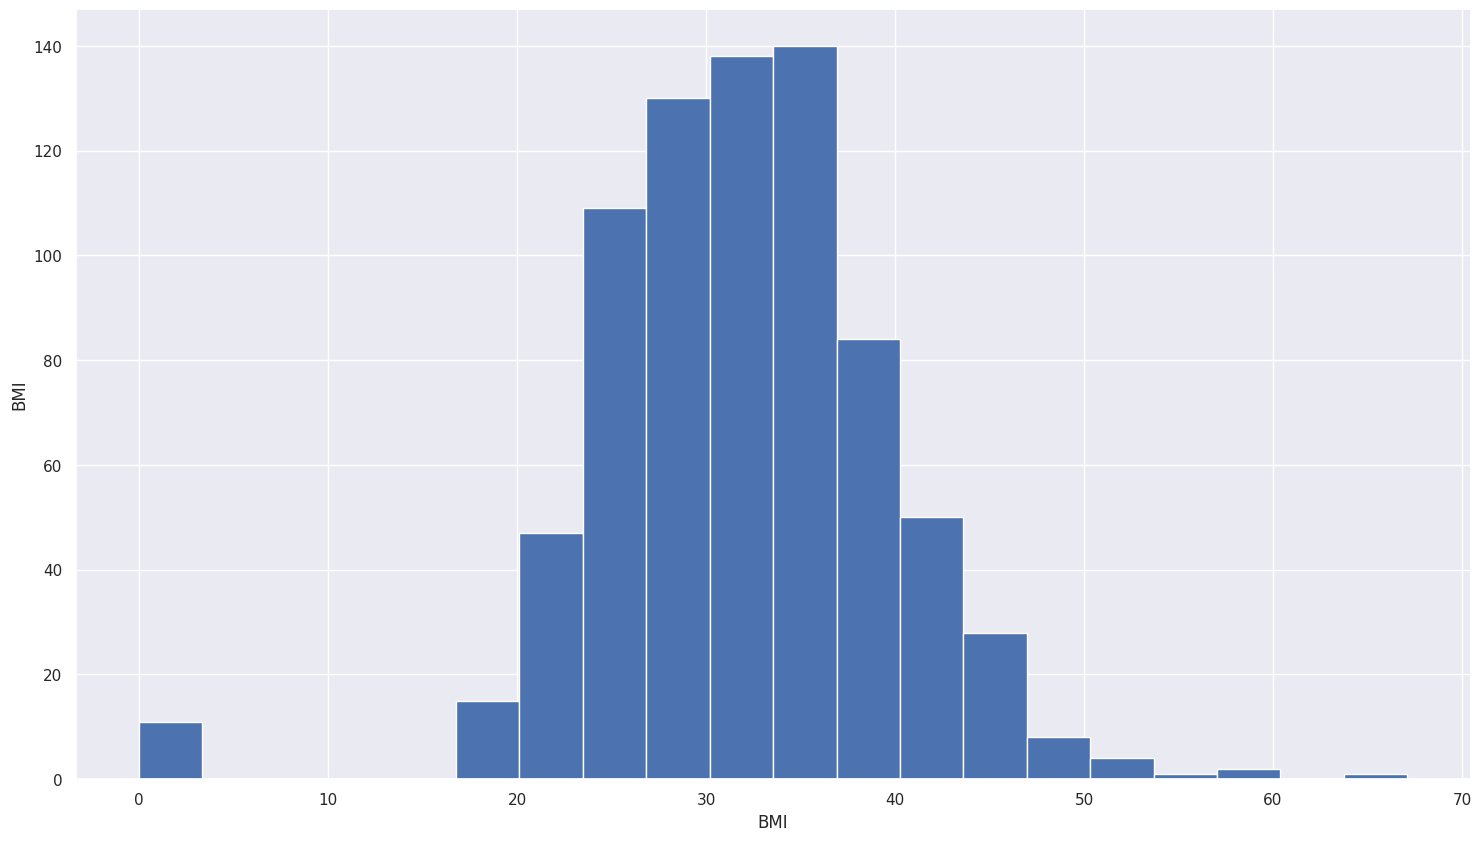

############### DiabetesPedigreeFunction ###############

count   768.0000

mean      0.4719

std       0.3313

min       0.0780

1%        0.0947

5%        0.1404

10%       0.1650

20%       0.2194

30%       0.2590

40%       0.3028

50%       0.3725

60%       0.4542

70%       0.5637

80%       0.6870

90%       0.8786

95%       1.1328

99%       1.6983

max       2.4200

Name: DiabetesPedigreeFunction, dtype: float64


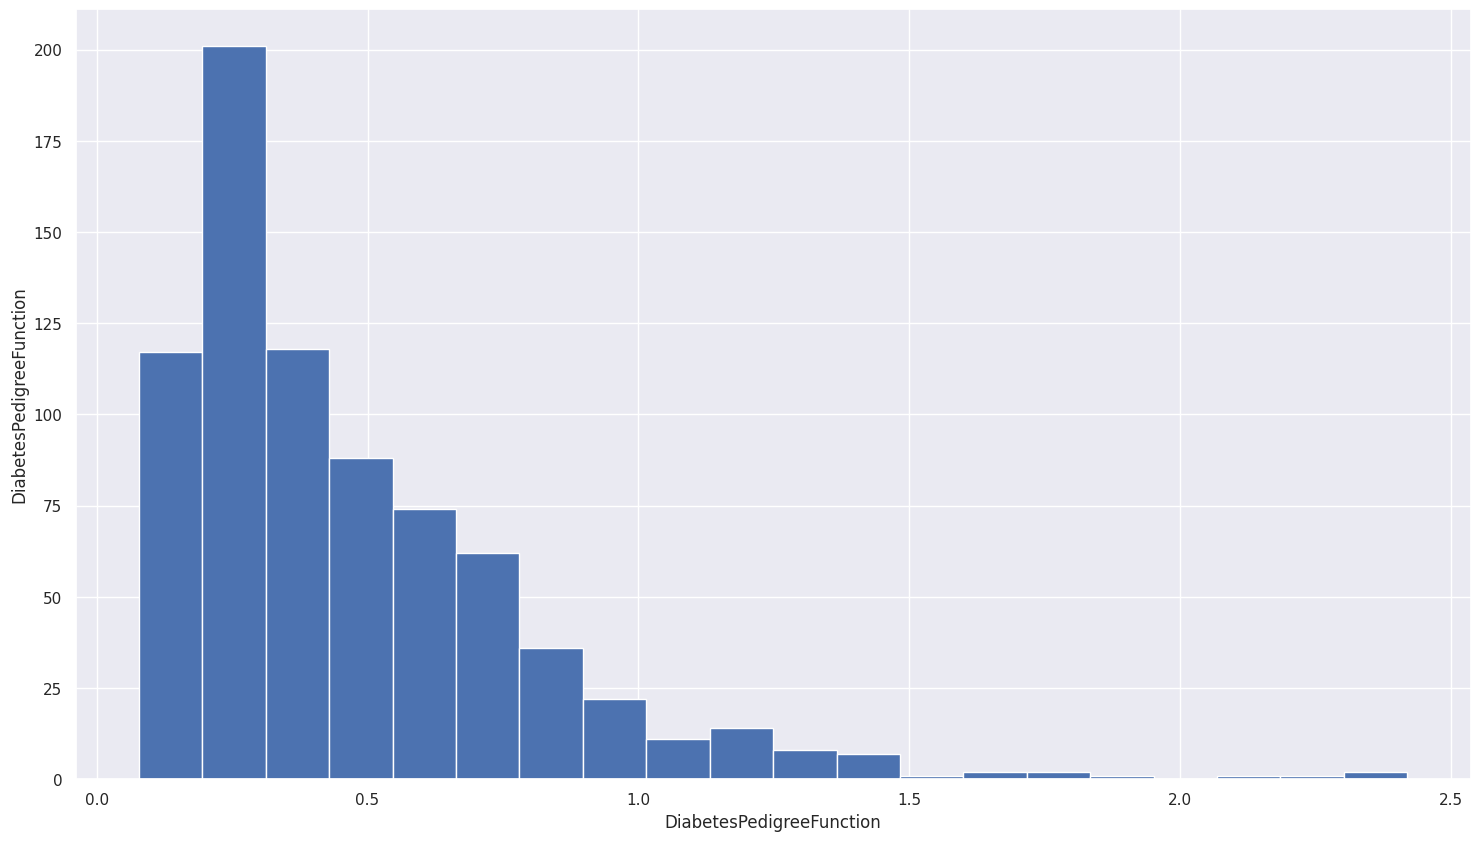

############### Age ###############

count   768.0000

mean     33.2409

std      11.7602

min      21.0000

1%       21.0000

5%       21.0000

10%      22.0000

20%      23.0000

30%      25.0000

40%      27.0000

50%      29.0000

60%      33.0000

70%      38.0000

80%      42.6000

90%      51.0000

95%      58.0000

99%      67.0000

max      81.0000

Name: Age, dtype: float64


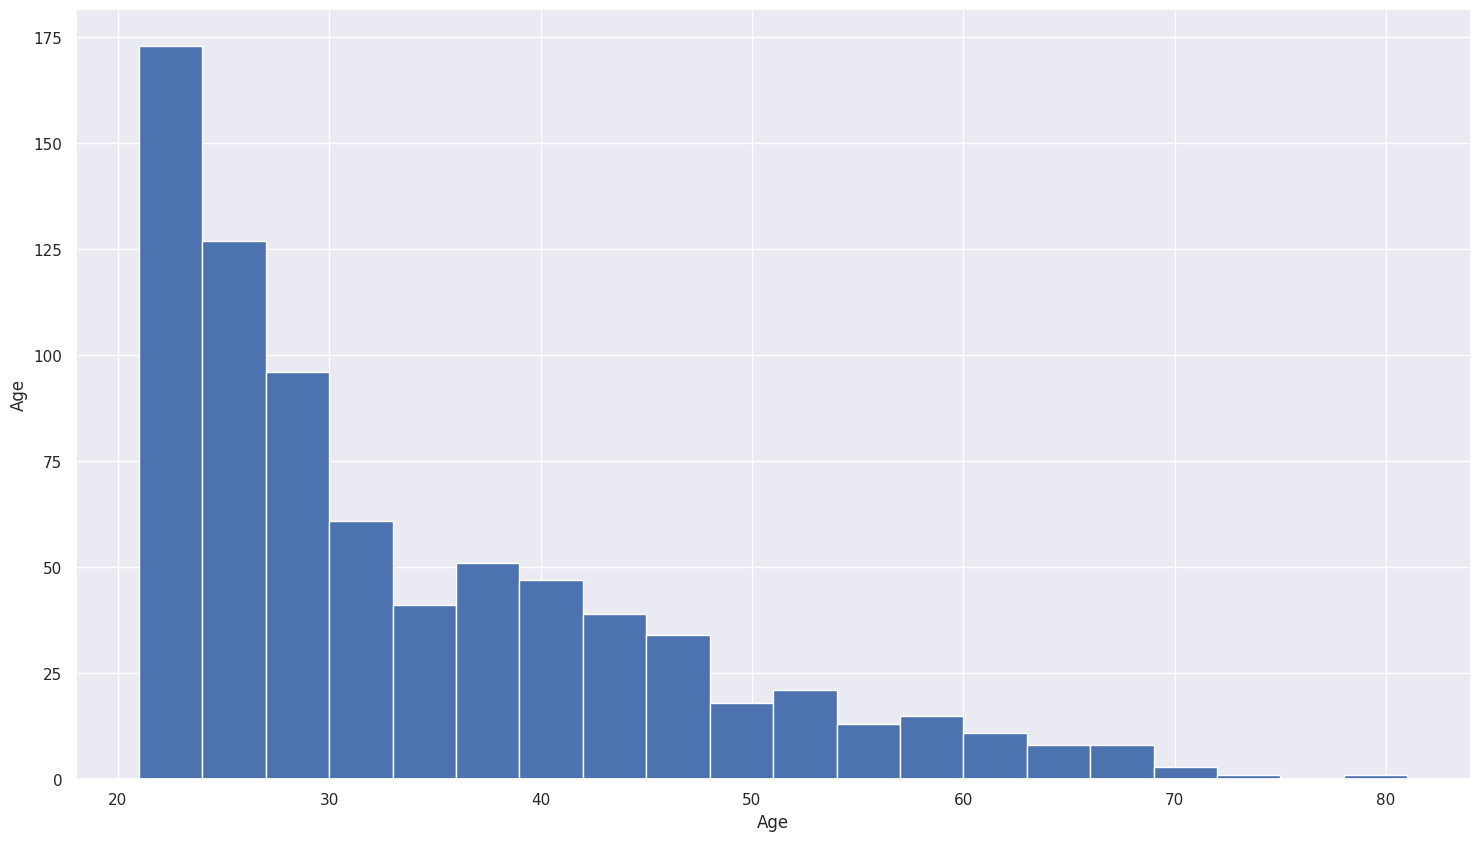

In [139]:
num_summary_df(df)

In [140]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  plt.figure(figsize=(12, 8))
  for index, col in enumerate(num_cols):
    plt.subplot(3, 3, index+1)
    plt.tight_layout()
    df[col].hist(bins=20)
    plt.title(col)

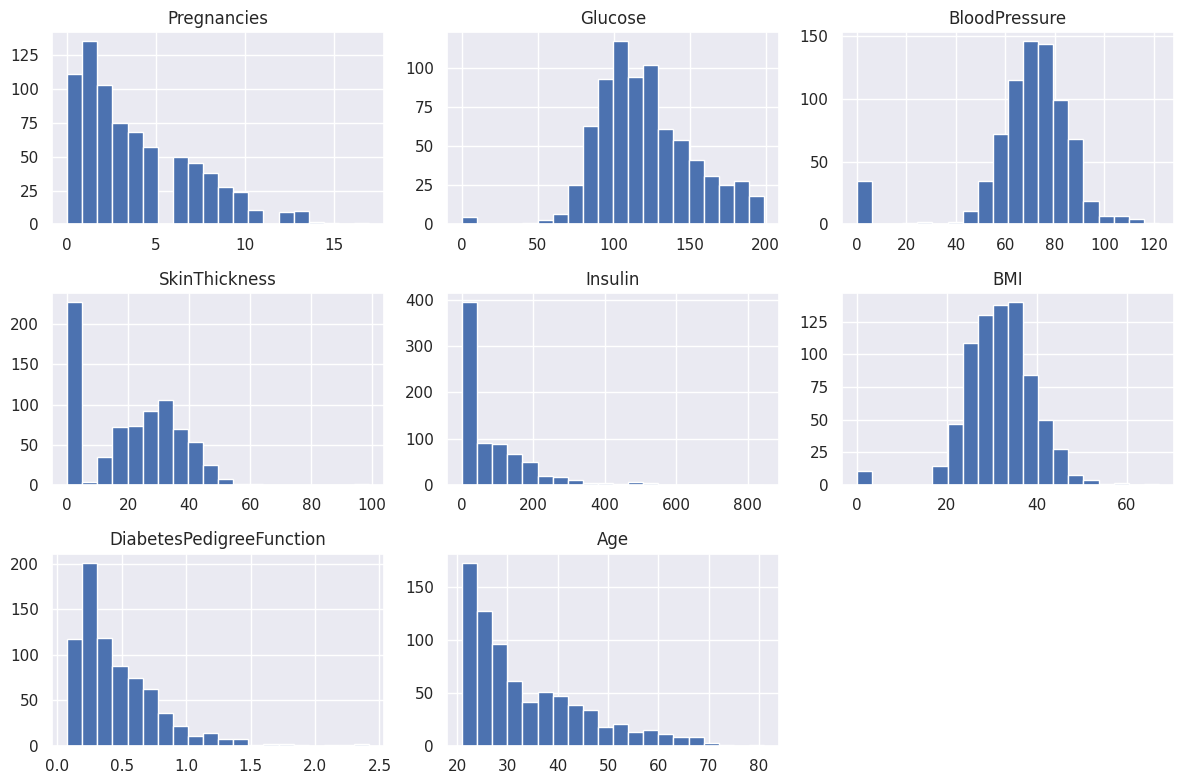

In [141]:
plot_num_summary(df)

# Target Analysis

In [142]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(f'################ {target} --> {numerical_col} #################')
    print(dataframe.groupby(target).agg({numerical_col: "mean"}))

In [143]:
def target_summary_with_num_df(dataframe, target):
    cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
    for col in num_cols:
      target_summary_with_num(dataframe, target, col)

In [144]:
target_summary_with_num_df(df, "Outcome")

################ Outcome --> Pregnancies #################

         Pregnancies

Outcome             

0             3.2980

1             4.8657

################ Outcome --> Glucose #################

         Glucose

Outcome         

0       109.9800

1       141.2575

################ Outcome --> BloodPressure #################

         BloodPressure

Outcome               

0              68.1840

1              70.8246

################ Outcome --> SkinThickness #################

         SkinThickness

Outcome               

0              19.6640

1              22.1642

################ Outcome --> Insulin #################

         Insulin

Outcome         

0        68.7920

1       100.3358

################ Outcome --> BMI #################

            BMI

Outcome        

0       30.3042

1       35.1425

################ Outcome --> DiabetesPedigreeFunction #################

         DiabetesPedigreeFunction

Outcome                          

0                

# Correlation Analysis

In [145]:
def correlated_cols(dataframe):
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['uint8', 'int64', 'float64']]
  corr = dataframe[num_cols].corr()
  sns.set(rc={'figure.figsize':(18, 10)})
  sns.heatmap(corr, cmap='RdBu', annot=True, fmt='.2f')
  plt.show()


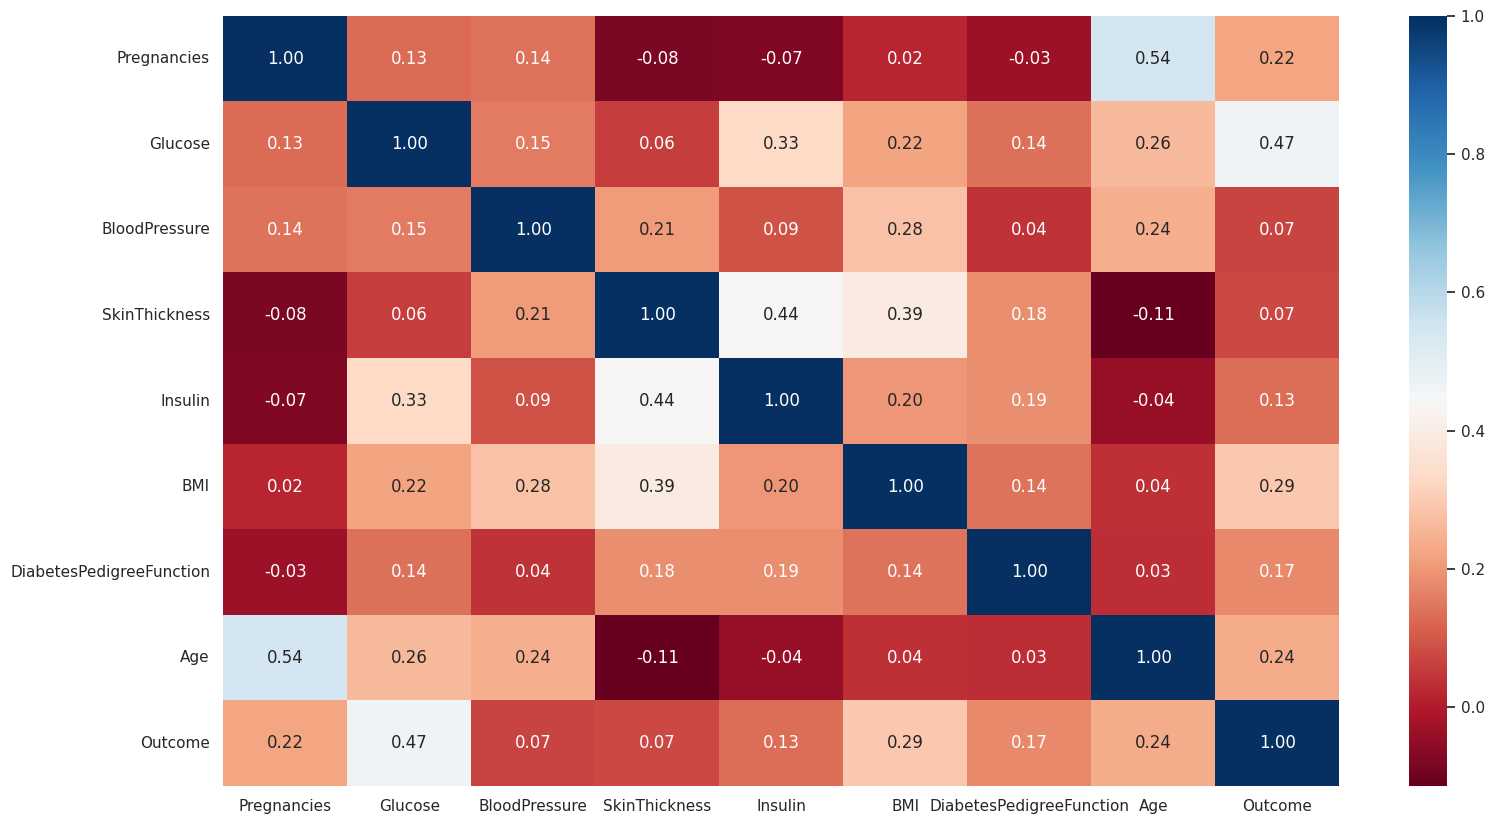

In [146]:
correlated_cols(df)

In [147]:
def high_correlated_cols(dataframe, corr_th=0.90, plot=False):
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['uint8', 'int64', 'float64']]
  corr = dataframe[num_cols].corr()
  corr_matrix = corr.abs()
  upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
  drop_list = [col for col in upper_triangle_matrix if any(upper_triangle_matrix[col] > corr_th)]
  if drop_list == 0:
    print('############### After Correlation Analysis, You Do not neead to remove variables #############')
  if plot:
      sns.set(rc={'figure.figsize':(18, 10)})
      sns.heatmap(corr, cmap='RdBu', annot=True, fmt='.2f')
      plt.show()

  return drop_list

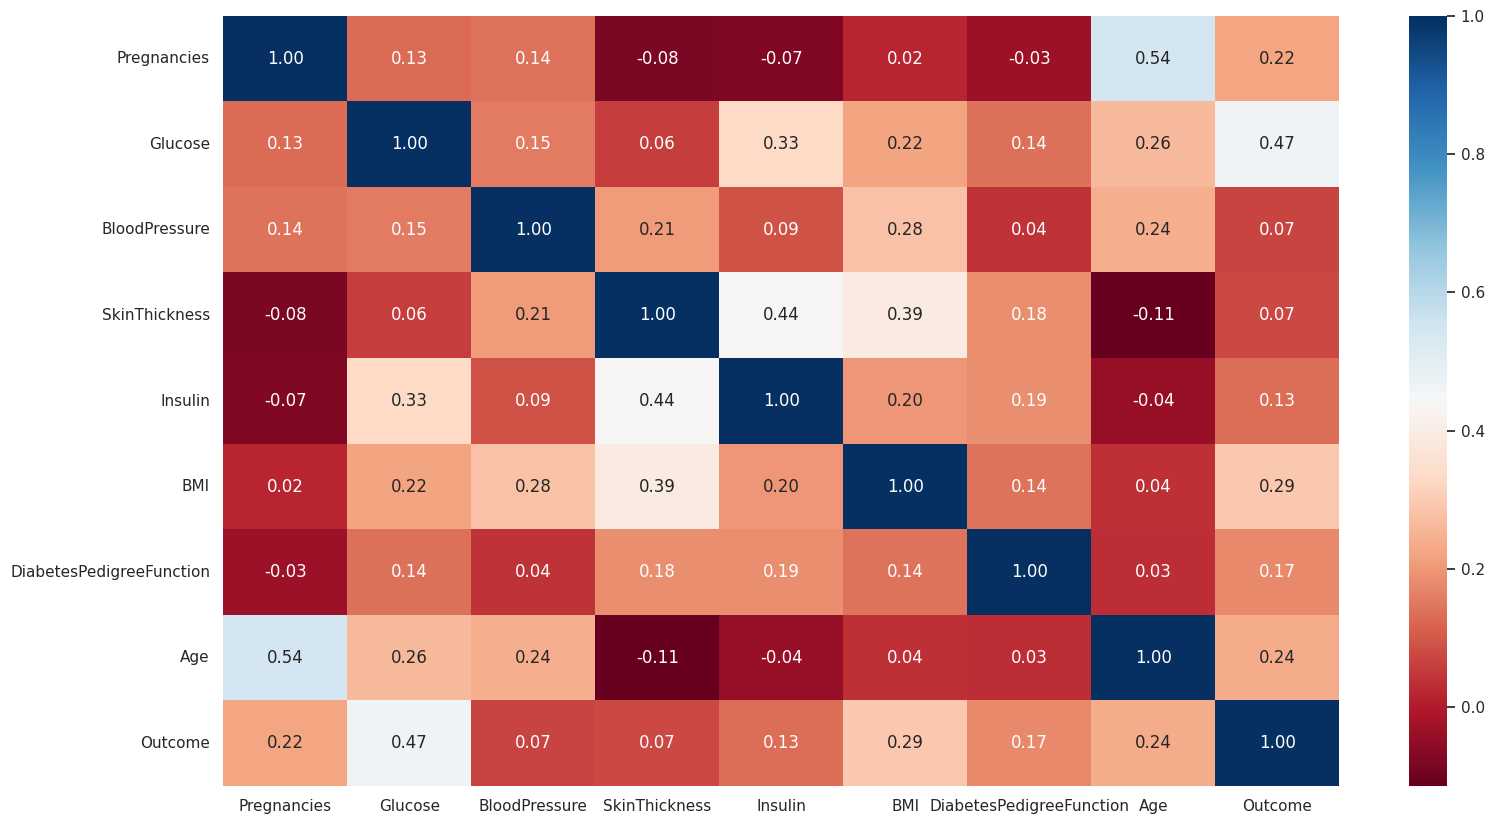

[]

In [148]:
high_correlated_cols(df, plot=True)

# Missing Value Analysis

In [149]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [150]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Outcome", "Pregnancies"])]
for col in zero_columns:
  df[col] = np.where(df[col]==0, np.nan, df[col])

In [151]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [152]:
def missing_values_table(dataframe):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
  print(missing_df)

In [153]:
missing_values_table(df)

               n_miss   ratio

Insulin           374 48.7000

SkinThickness     227 29.5600

BloodPressure      35  4.5600

BMI                11  1.4300

Glucose             5  0.6500


In [154]:
def fill_na_with_median(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [155]:
df = fill_na_with_median(df)

In [156]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# Create a Base Model: Random Forest Classifier

In [157]:
def RF_Model(dataframe, target, test_size=0.30, results=False, plot_importance=False, save_model=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  rf_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)
  if results:
    acc_train = accuracy_score(y_train, rf_model.predict(X_train))
    acc_test = accuracy_score(y_test, rf_model.predict(X_test))
    r2 = rf_model.score(X, y)
    r2_train = rf_model.score(X_train, y_train)
    r2_test = rf_model.score(X_test, y_test)
    cv_train = cross_val_score(rf_model, X_train, y_train, cv=5).mean()
    cv_test = cross_val_score(rf_model, X_test, y_test, cv=5).mean()
    cv_results = cross_validate(rf_model, X, y, cv=5, scoring=["accuracy", "f1", "recall", "precision", "roc_auc"])

    print(20*"*", "Accuracy & Results", 20*"*")
    print("Accuracy Train: ", "%.3f" % acc_train)
    print("Accuracy Test: ", "%.3f" % acc_test)
    print("R2 Train: ", "%.3f" % r2_train)
    print("R2 Test: ", "%.3f" % r2_test)
    print("Cross Validation Train:", "%.3f" % cv_train)
    print("Cross Validation Test:", "%.3f" % cv_test)
    print("Cross Validation (Accuracy):", "%.3f" % cv_results['test_accuracy'].mean())
    print("Cross Validation (F1): ", "%.3f" % cv_results['test_f1'].mean())
    print("Cross Validation (Precision):", "%.3f" % cv_results['test_precision'].mean())
    print("Cross Validation (Recall):", "%.3f" % cv_results['test_recall'].mean())
    print("Cross Validation (ROC Auc):", "%.3f" % cv_results['test_roc_auc'].mean())

  if plot_importance:
    feature_imp = pd.DataFrame({"Value": rf_model.feature_importances_, "Feature":X.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    plt.show()

  if save_model:
    joblib.dump(rf_model, "rf_model.pkl")

  return rf_model


******************** Accuracy & Results ********************

Accuracy Train:  1.000

Accuracy Test:  0.749

R2 Train:  1.000

R2 Test:  0.749

Cross Validation Train: 0.756

Cross Validation Test: 0.719

Cross Validation (Accuracy): 0.764

Cross Validation (F1):  0.635

Cross Validation (Precision): 0.692

Cross Validation (Recall): 0.590

Cross Validation (ROC Auc): 0.831


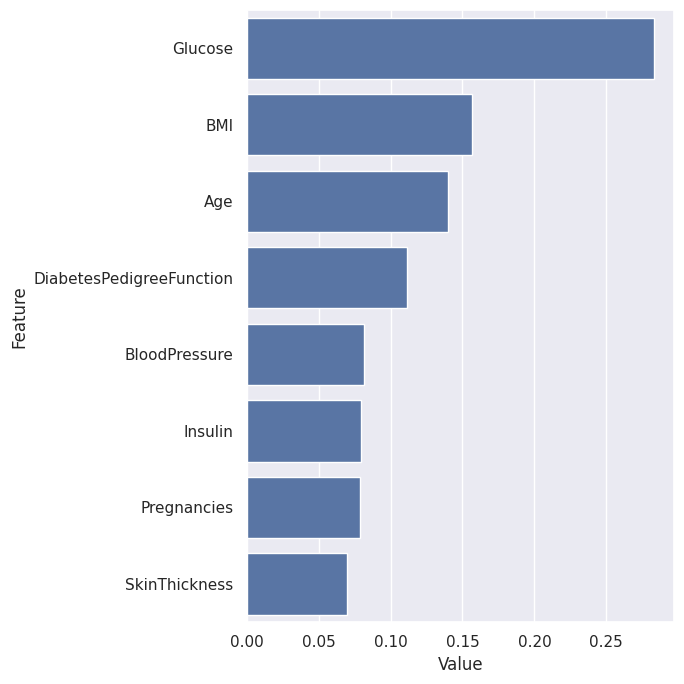

In [158]:
rf_model = RF_Model(df, "Outcome", results=True, plot_importance=True, save_model=True)

# Loading a Base Model and Prediction

In [159]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [160]:
model_disc = load_model("rf_model.pkl")

In [161]:
X = df.drop("Outcome", axis=1)
x = X.sample(1).values.tolist()

In [162]:
model_disc.predict(pd.DataFrame(X))[0]

1

In [163]:
df.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0000,72.0000,35.0000,125.0000,33.6000,0.6270,50,1


In [164]:
sample2 = [3, 165, 68, 38, 115, 30, 0.58, 32]

In [165]:
model_disc.predict(pd.DataFrame(sample2).T)[0]

1

# Model Tuning

In [166]:
def RF_Model_Tuned(dataframe, target, test_size=0.30, results=False, plot_importance=False, save_model=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  rf_model = RandomForestClassifier(random_state=42)
  rf_params = {
    "max_depth": [2, 5, 8],
    "max_features": [2, 5],
    "n_estimators": [500, 1000],
    "min_samples_split": [5, 10]
  }
  rf_cv_model = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)
  rf_model_tuned = rf_model.set_params(**rf_cv_model.best_params_).fit(X, y)
  if results:
    acc_train = accuracy_score(y_train, rf_model_tuned.predict(X_train))
    acc_test = accuracy_score(y_test, rf_model_tuned.predict(X_test))
    r2 = rf_model_tuned.score(X, y)
    r2_train = rf_model_tuned.score(X_train, y_train)
    r2_test = rf_model_tuned.score(X_test, y_test)
    cv_train = cross_val_score(rf_model_tuned, X_train, y_train, cv=5).mean()
    cv_test = cross_val_score(rf_model_tuned, X_test, y_test, cv=5).mean()
    cv_results = cross_validate(rf_model_tuned, X, y, cv=5, scoring=["accuracy", "f1", "recall", "precision", "roc_auc"])

    print(20*"*", "Accuracy & Results", 20*"*")
    print("Accuracy Train: ", "%.3f" % acc_train)
    print("Accuracy Test: ", "%.3f" % acc_test)
    print("R2 Train: ", "%.3f" % r2_train)
    print("R2 Test: ", "%.3f" % r2_test)
    print("Cross Validation Train:", "%.3f" % cv_train)
    print("Cross Validation Test:", "%.3f" % cv_test)
    print("Cross Validation (Accuracy):", "%.3f" % cv_results['test_accuracy'].mean())
    print("Cross Validation (F1): ", "%.3f" % cv_results['test_f1'].mean())
    print("Cross Validation (Precision):", "%.3f" % cv_results['test_precision'].mean())
    print("Cross Validation (Recall):", "%.3f" % cv_results['test_recall'].mean())
    print("Cross Validation (ROC Auc):", "%.3f" % cv_results['test_roc_auc'].mean())

  if plot_importance:
    feature_imp = pd.DataFrame({"Value": rf_model.feature_importances_, "Feature":X.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    plt.show()

  if save_model:
    joblib.dump(rf_model, "rf_model_tuned.pkl")

  return rf_model_tuned


Fitting 5 folds for each of 24 candidates, totalling 120 fits

******************** Accuracy & Results ********************

Accuracy Train:  0.931

Accuracy Test:  0.913

R2 Train:  0.931

R2 Test:  0.913

Cross Validation Train: 0.769

Cross Validation Test: 0.741

Cross Validation (Accuracy): 0.760

Cross Validation (F1):  0.643

Cross Validation (Precision): 0.677

Cross Validation (Recall): 0.620

Cross Validation (ROC Auc): 0.834


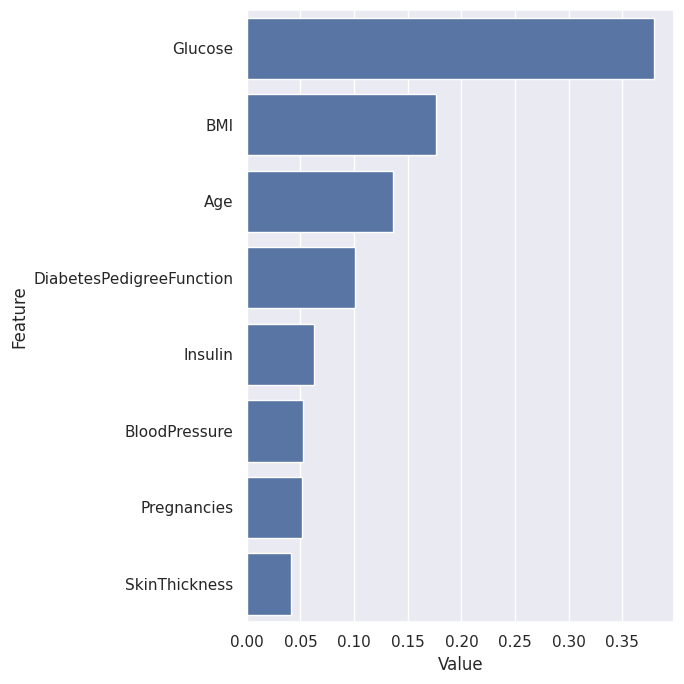

In [167]:
rf_model_tuned = RF_Model_Tuned(df, "Outcome", results=True, plot_importance=True, save_model=True)

# Loading a Tuned Model and Prediction

In [168]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [169]:
model_disc = load_model("rf_model_tuned.pkl")

In [170]:
model_disc.predict(pd.DataFrame(X))[0]

1

In [171]:
df.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0000,72.0000,35.0000,125.0000,33.6000,0.6270,50,1


In [172]:
sample2 = [3, 165, 68, 38, 115, 30, 0.58, 32]

In [173]:
model_disc.predict(pd.DataFrame(sample2).T)[0]

1